## Dogs v Cats super-charged!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz=299
arch=resnext50
bs=28

In [5]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [8]:
learn.fit(1e-2, 1)
learn.precompute=False

A Jupyter Widget

[ 0.       0.03025  0.02246  0.99306]                          



In [10]:
learn.fit(1e-2, 2, cycle_len=1)

A Jupyter Widget

[ 0.       0.03622  0.01899  0.99504]                         
[ 1.       0.02817  0.01762  0.99454]                         



In [15]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [17]:
learn.fit(lr, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.03577  0.01557  0.99504]                         
[ 1.       0.03684  0.01287  0.99554]                         
[ 2.       0.02823  0.01572  0.99653]                         



In [18]:
learn.save('224_all_50')

In [9]:
learn.load('224_all_50')

In [19]:
log_preds,y = learn.TTA()
accuracy(log_preds,y)

0.99750000000000005

## Analyzing results

In [20]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[996   4]
 [  1 999]]


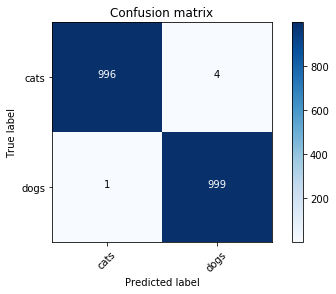

In [22]:
plot_confusion_matrix(cm, data.classes)

In [23]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


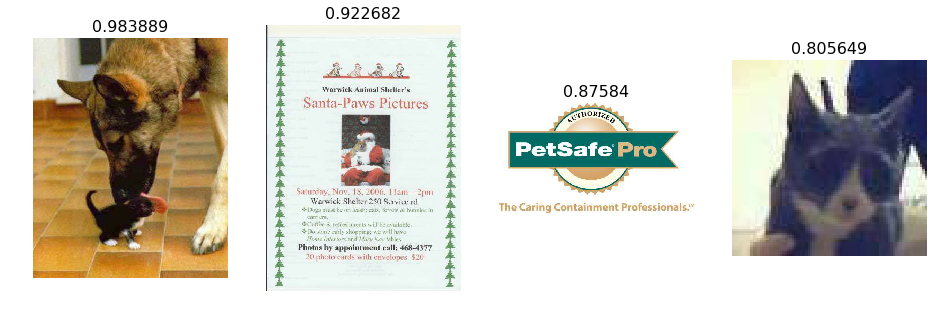

In [28]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


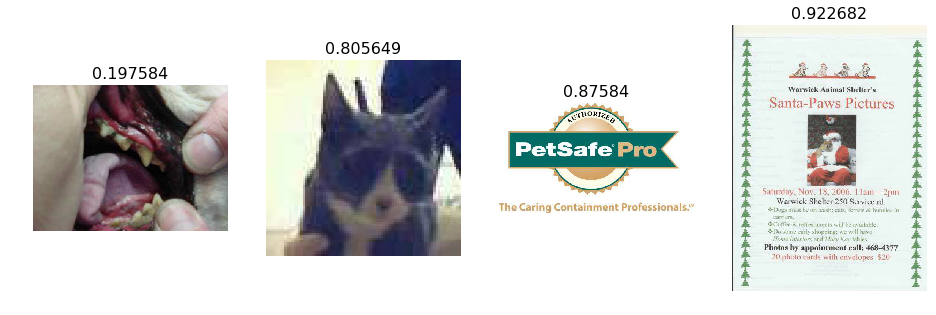

In [29]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")